In [1]:
import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.normpath(os.path.join(
    '..', '..'))),

from tta_uia_segmentation.src.dataset.dataset_in_memory_for_ddpm import get_datasets
from tta_uia_segmentation.src.models.io import define_and_possibly_load_lcddpm, load_norm_from_configs_and_cpt
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.utils.utils import torch_to_numpy
from tta_uia_segmentation.src.dataset.utils import onehot_to_class

plot_torch_img = lambda img_: plt.imshow(torch_to_numpy(img_.squeeze().permute(1,2,0)), cmap='gray')


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-10-31 18:38:58.019367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 18:38:58.019430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 18:38:58.023091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 18:38:58.032738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow 

In [2]:
run_dir = "/cluster/home/jbermeo/logs/ddpm/subcortical_structures/hcp_t1/lddpm/no_x_attn/normalized_imgs_3x3_norm_filters/10_30/dim_256_dim_mults_1_2_4_4_bs_128_1_gpu"
#run_dir = "/scratch/jbermeo/logs/brain/lddpm/no_x_attn/hcp_t1/normalized_imgs/3x3_norm_filters/10_25/dim_64_dim_mults_1_2_2_2_bs_32" 
milestone = 5


ddpm_train_cfg = load_config(os.path.join(run_dir, 'params.yaml'))

dataset_name = ddpm_train_cfg['training']['dataset'] 

train_cfg = ddpm_train_cfg['training']['lddpm']
train_cfg_norm = ddpm_train_cfg['training']['norm']
model_cfg = ddpm_train_cfg['model']['lddpm_unet']
model_cfg_norm = ddpm_train_cfg['model']['normalization_2D']
dataset_cfg = ddpm_train_cfg['dataset'][dataset_name]

n_classes = dataset_cfg['n_classes']

### Load example image

In [3]:
train_cfg['norm_dir']

'/scratch/tmp.13734009.jbermeo/models/segmentation/subcortical_structures/hcp_t1/smoothing_denominator_1em10_diceloss_all_classes'

In [4]:
norm_dir = os.path.join(os.environ['MODEL_DIR'], 'segmentation/subcortical_structures/hcp_t1/smoothing_denominator_1em10_diceloss_all_classes')

In [5]:
norm = load_norm_from_configs_and_cpt(
    model_params_norm=model_cfg_norm,
    cpt_fp=os.path.join(norm_dir, train_cfg_norm['checkpoint_best']),
    device='cpu'
)


In [6]:
def append_after_str(base_path, target_path, split_str):
    # Find the first occurrence of "data" in the target path
    split_index = target_path.find(split_str)
    
    # Ensure "data" was found in the target path
    if split_index == -1:
        raise ValueError(f"'{split_str}' not found in target path.")
    
    # Extract everything after "data"
    suffix = target_path[split_index + len(split_str):]
    
    # Join base path and suffix to form the final path
    combined_path = os.path.join(base_path, suffix.strip('/'))
    
    return combined_path
    
dataset_cfg['paths_processed'] = {k:append_after_str(os.environ['DATA_DIR'], v, 'data') 
 for k, v in dataset_cfg['paths_processed'].items() }

In [7]:

(dataset,) = get_datasets(
    dataset_name    = dataset_name,
    splits          = ['train'],
    norm            = norm,
    paths           = dataset_cfg['paths_processed'],
    use_original_imgs = train_cfg['use_original_imgs'],
    one_hot_encode  = True,
    normalize       = train_cfg['normalize'],
    norm_q_range    = train_cfg['norm_q_range'],
    paths_original  = dataset_cfg['paths_original'],
    image_size      = train_cfg['image_size'],
    resolution_proc = dataset_cfg['resolution_proc'],
    dim_proc        = dataset_cfg['dim'],
    n_classes       = n_classes,
    aug_params      = train_cfg['augmentation'],
    rescale_factor  = train_cfg['rescale_factor'],
    load_original   = False,
    return_imgs_in_rgb = train_cfg['vae_pretrained_on_nat_images']
)

dataset.set_augmentation(False) 

In [8]:
img, seg, *_ = dataset[120]
img = img.unsqueeze(0)
seg = seg.unsqueeze(0).float()

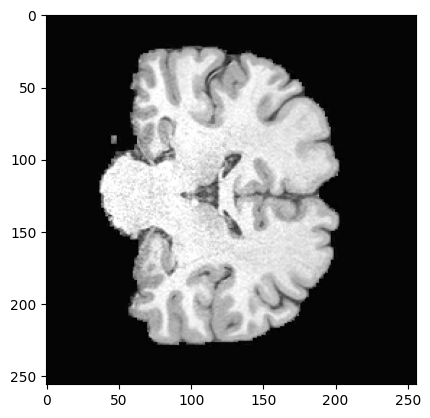

In [9]:
plt.imshow(torch_to_numpy(img.squeeze().permute(1,2,0)), cmap='gray')

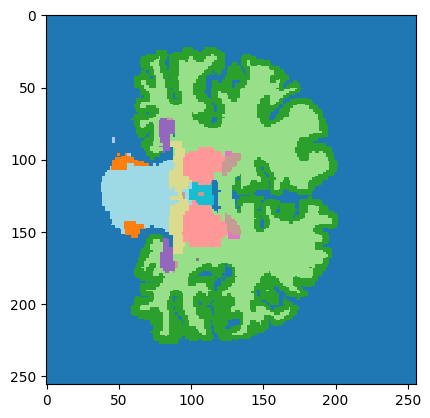

In [10]:
plt.imshow(torch_to_numpy(onehot_to_class(seg).squeeze()), cmap='tab20', interpolation='none')

### Load L-DDPM

In [11]:
milestone = 5
cpt_fp = os.path.join(run_dir, f'model-{milestone}.pt')

In [12]:
ddpm = define_and_possibly_load_lcddpm(
    train_config=train_cfg,
    model_config=model_cfg,
    n_classes=n_classes,
    cpt_fp=cpt_fp,
    return_ema_model=True,
    device='cpu'
)

KeyboardInterrupt: 

# Check Our sampling methods with DDPM and DDIM

In [ ]:
ddpm._noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.02,
  "beta_schedule": "sigmoid",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `beta_schedule` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'beta_schedule' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.beta_schedule'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 31.60it/s]


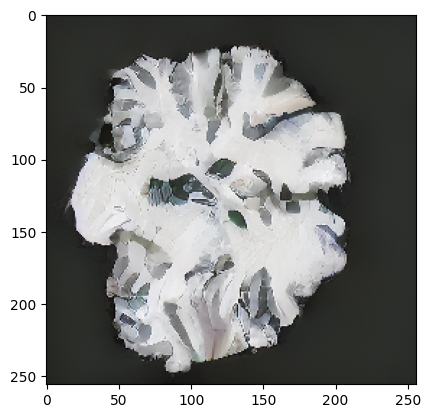

In [ ]:
sampled_img = ddpm.ddpm_sample(
    img.shape, seg,
    num_sample_timesteps=100,
    show_progress=True)
plot_torch_img(sampled_img)

100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s]


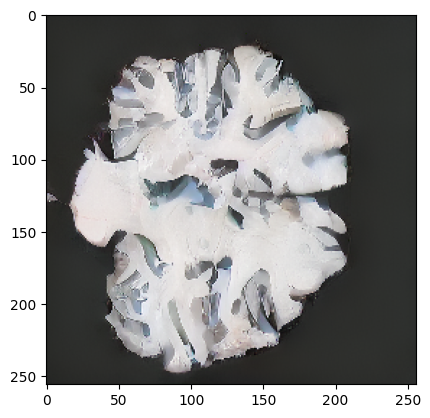

In [ ]:
sampled_img = ddpm.ddpm_sample(
    img.shape, seg,
    num_sample_timesteps=1000,
    show_progress=True)
plot_torch_img(sampled_img)

In [ ]:
sampled_img = ddpm.ddpm_sample(
    img.shape, seg,
    num_sample_timesteps=1000,
    rescale_betas_zero_snr=True,
    show_progress=True)
plot_torch_img(sampled_img)

/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `beta_schedule` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'beta_schedule' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.beta_schedule'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


TypeError: diffusers.configuration_utils.ConfigMixin.from_config() got multiple values for keyword argument 'rescale_betas_zero_snr'

In [ ]:
DDPMScheduler.from_config( 
            ddpm._noise_scheduler.config,
            beta_schedule='sigmoid',
            rescale_betas_zero_snr=True,
        )

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.02,
  "beta_schedule": "sigmoid",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "rescale_betas_zero_snr": true,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s]


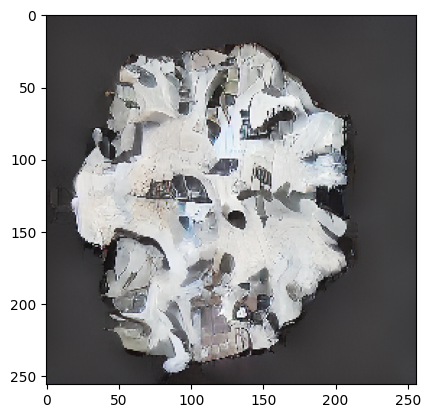

In [ ]:
sampled_img = ddpm.ddpm_sample(
    img.shape, seg,
    beta_schedule='linear',
    num_sample_timesteps=1000,
    show_progress=True)
plot_torch_img(sampled_img)

100%|██████████| 1000/1000 [00:30<00:00, 33.10it/s]


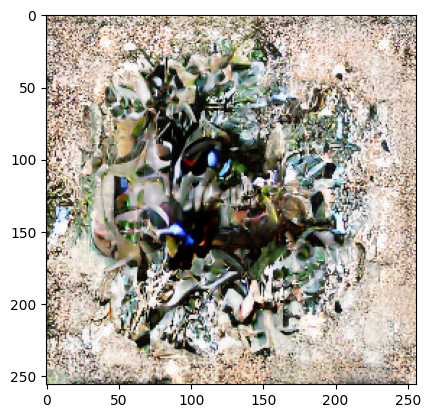

In [ ]:
sampled_img = ddpm.ddim_sample(
    img.shape, seg,
    beta_schedule='linear',
    num_sample_timesteps=1000,
    show_progress=True)
plot_torch_img(sampled_img)

In [ ]:
sampled_img.shape

torch.Size([1, 3, 256, 256])

## Check a very simple sampling loop

In [ ]:
from diffusers import DDPMScheduler, DDIMScheduler

In [ ]:
img.shape

torch.Size([1, 3, 256, 256])

In [ ]:
ddpm.ddpm_sample()

TypeError: ConditionalLatentGaussianDiffusion.ddpm_sample() missing 2 required positional arguments: 'img_shape' and 'x_cond'

In [ ]:
ddpm.sample()

In [ ]:
num_inference_steps = 100
scheduler =
scheduler.set_timesteps(num_inference_steps)

for t in self.progress_bar(self.scheduler.timesteps):
    # 1. predict noise model_output
    model_output = self.unet(image, t).sample

    # 2. compute previous image: x_t -> x_t-1
    image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

UNet2DModel(
  (conv_in): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): AttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Attention(
          (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (to_q): Linear(in_features=64, out_features=64, bias=True)
          (to_k): Linear(in_features=64, out_features=64, bias=True)
          (to_v): Linear(in_features=64, out_features=64, bias=True)
          (to_out): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine

In [ ]:
pipe = DDPMPipeline(